# Average grain size distribution 

- I am using the dataframe created in the previous file to calculate the average HH corr
- Since I have different scansizes and pixel numbers (and therefore, different stepsize), I take the smallest stepsize and I create the interpolated HH corr function over this new scale.
- Once I have the interpolated functions, I can easily average them.

In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd
import pickle

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


from matplotlib import cm
from skimage import data, img_as_float

import plotly.graph_objects as go
import plotly.express as px

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.stats import sem

In [27]:
debug = True 

path = "/Users/sfiligoj/Desktop/Thesis/Data Analysis/AFM/SSP"
#old data is in path = "/Users/sfiligoj/Google Drive/Crispies/Ru/Data analysis with Python/Method1/SSP_all"
os.chdir(path)
   
# Load the dictionary back from the pickle file.
z_score = 6

new_folder_name="LastTRY"
df = pickle.load( open(f"{new_folder_name}/save_z{z_score}_NEW.p", "rb" ) )

if debug: print(f'Created dataframe with only a specific density or temperature')
if debug: dfTRY = df[df.density == 'L']
if debug: dfTRY = dfTRY[dfTRY.temp == '700']
dfTRY

Created dataframe with only a specific density or temperature


,filename,density,temp,xi,hhcorr,scansize,n_pix,rms,rms_sq,alpha
36,015,L,700,9.885274,"[0.146329176972496, 0.3236800622224182, 0.4729...",1000,512,0.683911,0.467735,0.571959
42,013,L,700,10.180767,"[0.13235963166776266, 0.297450399418743, 0.442...",1000,512,0.674145,0.454471,0.583432
45,011,L,700,13.535293,"[0.15142311362158709, 0.34665598081056503, 0.5...",1000,512,0.873879,0.763665,0.596899


In [74]:
# df.drop(index=12,inplace= True) #800C 008
# df.drop(index=4,inplace= True) #700C 032
# df.drop(index=17,inplace= True) #500C 001
# df.drop(index=31,inplace= True) # 600C 027
# df.drop(index=22,inplace= True) # 600C 025
# df.drop(index=45,inplace= True) #800C 012 no hole

df.drop(index=27,inplace= True) #700C 002 

# Calculation of interpolated HHcorr's
- Since x_new was different for L, LH and H I had to crate a loop through the densities.

In [75]:
densities = ['L','H','LH']
# we add a new column to the dataframe that describes the px_size
df['px_size'] = df.scansize / df.n_pix

# we create Xdelta for each row, all at once
x_delta = [np.arange(px_size, scan_size+px_size, px_size) for px_size, scan_size in zip(df.px_size, df.scansize)] 
# we take the minimun px_size, and interpolate all HHcorr at x values whose delta is that minimum
min_dx = min(df.px_size)
min_scansize = min(df.scansize)
if True: print(min_dx, min_scansize)
x_new = np.arange(min_dx, min_scansize, min_dx) # x_new is the new range on which I want to interpolate the data
df['hhcorr_interp'] = [np.interp(x_new, x, y) for x,y in zip(x_delta, df.hhcorr)]   

0.9765625 500


# Set density for Si

The file relative to Si has to be assigned a specific density (L, H or LH) depending on 
which density I want to plot in Sec. 5.
By default, it is LH. To change it to either L or H I do the folliwing:

In [76]:
# select the Silicon measurement
Silicon = df[df.temp=='20']

for Si_copy_no, density in zip([1,2],['L','H']):
    temp = Silicon
    temp.density = density
#     df = df.append([Silicon], ignore_index=True)
    df = df.append(Silicon, ignore_index=True)

In [89]:
temperatures = ['20','25','250','500','600','700','800']
densities = ['H','LH','L']

df_R = pd.DataFrame(columns= 
                   ['density',
                    'temp', 
                    'rms',
                    'rms err',
                    'alpha',
                    'alpha err',
                    'xi mean',
                    'xi err'])

AvRMS = {}
AvCorrLen={}
AvRMSsq={}
AvAlpha={}
for dens in densities:
   
    AvRMS[dens] = {}
    AvCorrLen[dens]={}
    AvRMSsq[dens]={}
    AvAlpha[dens]={}
    
    for temp in temperatures:
       
        AvRMS[dens][temp] = {}
        AvCorrLen[dens][temp] ={}
        AvRMSsq[dens][temp]={}
        AvAlpha[dens][temp]={}
        # create the selection
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]      

        all_rms = np.array(selection.rms.tolist())
        AvRMS[dens][temp]['value'] = all_rms.mean(axis=0)
        all_xi = np.array(selection.xi.tolist())
        AvCorrLen[dens][temp]['value']= all_xi.mean(axis=0)
        all_RMSsq = np.array(selection.rms_sq.tolist())
        AvRMSsq[dens][temp]['value'] = all_RMSsq.mean(axis=0)
        all_alpha = np.array(selection.alpha.tolist())
        AvAlpha[dens][temp]['value'] = all_alpha.mean(axis=0)

        # Check if I have only one data file per temperature (otherwise I get an error when I calculate SEM):
        if len(selection)==1:
            print(f"For temp={temp} and dens={dens}, there's only 1 measurement")
            # set a relative error of 6%: 
          
            err_RMS = 0.06*AvRMS[dens][temp]['value']
            err_xi = 0.06*AvCorrLen[dens][temp]['value']
            err_alpha = 0.06*AvAlpha[dens][temp]['value']
            
            AvRMS[dens][temp]['err']   = err_RMS
            AvAlpha[dens][temp]['err'] = err_alpha 
            AvCorrLen[dens][temp]['err']= err_xi

        else:
            # calculate standard error:
            
            err_RMS = sem(all_rms, axis = 0)
            err_xi = sem(all_xi, axis=0)
            err_alpha = sem(all_alpha, axis=0)

            AvRMS[dens][temp]['err']   = err_RMS
            AvAlpha[dens][temp]['err'] = err_alpha 
            AvCorrLen[dens][temp]['err']= err_xi

            df_R = df_R.append( 
                {'density': dens,
                 'temp': temp,  
                 'rms': AvRMS[dens][temp]['value'],
                 'rms err':  AvRMS[dens][temp]['err'],
                 'alpha': AvAlpha[dens][temp]['value'],
                 'alpha err': AvAlpha[dens][temp]['err'],
                 'xi mean': AvCorrLen[dens][temp]['value'],
                 'xi err': AvCorrLen[dens][temp]['err']
                },
                ignore_index=True)
    
    df_R.to_excel(f"{new_folder_name}/output_z_{z_score}.xlsx")  # doctest: +SKIP

For temp=20 and dens=H, there's only 1 measurement
For temp=20 and dens=LH, there's only 1 measurement
For temp=20 and dens=L, there's only 1 measurement


# Calculation of Average HHcorr
    Blueprint -> AvHHcorr [density] [temperature]
    - we take the interpolated HHcorr from the "selection" DataFrame
    - we create an array, where each HHcorr from a different measurement is a full row
    - when we average on the columns, we get the average_HHcorr

In [69]:
temperatures = ['20','25','250','500','600','700','800']
densities = ['L','H','LH']

np.seterr(all='raise')

AvHHcorr = {} 
AvRMS = {}
AvCorrLen={}
AvRMSsq={}
AvAlpha={}
for dens in densities:
    AvHHcorr[dens] = {}
    AvRMS[dens] = {}
    AvCorrLen[dens]={}
    AvRMSsq[dens]={}
    AvAlpha[dens]={}
    for temp in temperatures:
        AvHHcorr[dens][temp] = {}
        AvRMS[dens][temp] = {}
        AvCorrLen[dens][temp] ={}
        AvRMSsq[dens][temp]={}
        AvAlpha[dens][temp]={}
        # create the selection
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]
        # pass from dataframe object to array
        all_hhcorr = np.array(selection.hhcorr_interp.tolist())

        AvHHcorr[dens][temp]['value'] = all_hhcorr.mean(axis = 0)
        all_rms = np.array(selection.rms.tolist())
        AvRMS[dens][temp]['value'] = all_rms.mean(axis=0)
        all_xi = np.array(selection.xi.tolist())
        AvCorrLen[dens][temp]['value']= all_xi.mean(axis=0)
        all_RMSsq = np.array(selection.rms_sq.tolist())
        AvRMSsq[dens][temp]['value'] = all_RMSsq.mean(axis=0)
        all_alpha = np.array(selection.alpha.tolist())
        AvAlpha[dens][temp]['value'] = all_alpha.mean(axis=0)

        # Check if I have only one data file per temperature (otherwise I get an error when I calculate SEM):
        if len(selection)==1:
            print(f"For temp={temp} and dens={dens}, there's only 1 measurement")
            # set a relative error of 6%: 
            err_HH = 0.06*AvHHcorr[dens][temp]['value']
            err_RMS = 0.06*AvRMS[dens][temp]['value']
            err_xi = 0.06*AvCorrLen[dens][temp]['value']
            err_alpha = 0.06*AvAlpha[dens][temp]['value']
            
            
            AvHHcorr[dens][temp]['err'] = err_HH
            AvHHcorr[dens][temp]['value_upper'] = AvHHcorr[dens][temp]['value'] + err_HH
            AvHHcorr[dens][temp]['value_lower'] = AvHHcorr[dens][temp]['value'] - err_HH
            AvRMS[dens][temp]['err']   = err_RMS
            AvAlpha[dens][temp]['err'] = err_alpha 
            AvCorrLen[dens][temp]['err']= err_xi

        else:
            # calculate standard error:
            err_HH = sem(all_hhcorr, axis = 0)
            err_RMS = sem(all_rms, axis = 0)
            err_xi = sem(all_xi, axis=0)
            err_alpha = sem(all_alpha, axis=0)

            AvHHcorr[dens][temp]['err'] = err_HH
            AvHHcorr[dens][temp]['value_upper'] = AvHHcorr[dens][temp]['value'] + err_HH
            AvHHcorr[dens][temp]['value_lower'] = AvHHcorr[dens][temp]['value'] - err_HH
            AvRMS[dens][temp]['err']   = err_RMS
            AvAlpha[dens][temp]['err'] = err_alpha 
            AvCorrLen[dens][temp]['err']= err_xi
        
else:
    print("Finished")

AttributeError: 'DataFrame' object has no attribute 'hhcorr_interp'

# Plot all Temperatures in one graph

In [27]:
temperatures = ['800','700','600','500','250','25']
named_colorscales = px.colors.named_colorscales()
colors = px.colors.sequential.Plasma_r[2:8]

Si = ['20']
col = ['black']

densities = ['H','LH','L']
symbols = ['circle-open', 'square-open', 'diamond-open']

for dens, symbol in zip(densities, symbols):
    
    fig = go.Figure()
    for temp, color in zip(temperatures, colors):

        label = f"{temp}°C"
        fig.add_trace(
            go.Scatter(
                x = x_new[:1000], 
                y = AvHHcorr[dens][temp]['value'][:1000],
                mode = 'lines+markers',
                name = label,
                marker = dict(color = color, 
                              symbol = symbol,
                              opacity = 1, 
                              size = 7,
                              line = dict(width = 1.5)
                             ),
                opacity = 0.8,
                line = dict(
                    color = color,
                    width = 1.5)
            )
        )
            
            
    for temp, color in zip(Si, col):

        label = f"Si"
        fig.add_trace(
            go.Scatter(
                x = x_new[:1000], 
                y = AvHHcorr[dens][temp]['value'][:1000],
                mode = 'lines + markers',
                name = label,marker = dict(color = 'black', 
                              symbol = 'x-thin',
                              size = 7,
                              line = dict(width=1.5)
                             ),
                opacity = 0.8,
                line = dict(
                    color = color,
                    dash = 'dash',
                    width = 1.5
                    )
            )
        )
        

        fig.update_layout(title={'text': f'Average HH-correlation function for {dens} density Ru', 
                        'xanchor':'center', 'yanchor': 'top', 'y':0.9,  'x':0.5},
                   xaxis=dict(title='Length scale, L (nm)', ticks="inside",
                              range=[np.log10(1.8),np.log10(1000)],
                              tickmode = "linear",
                              tick0 = np.log10(1),
                              dtick = np.log10(10),
#                               linewidth=1, linecolor='black', mirror=True
                             ),
                   yaxis=dict(title='HHcorr (nm²)', ticks="inside",
#                               range=[np.log10(min(AvHHcorr[dens][temp]['value']*0.8)),
#                                      np.log10(int(max(AvHHcorr[dens]['800']['value']*1.5)))],
                              tickmode = "linear",
                              tick0 = np.log10(5),
                              dtick = np.log10(0.1),
#                               linewidth=1, linecolor='black', mirror=True
                             ),
#                    template ="plotly_white",
                   width=750, height=600
                  )
        
    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")
         
    fig.write_image(f"{new_folder_name}/AFM_Average HH function - Ru_{dens}_withSi_z{z_score}.png")
    fig.write_image(f"{new_folder_name}/AFM_Average HH function - Ru_{dens}_withSi_z{z_score}.svg")
    
fig.show()


# Plot As-Deposited for different densities

In [28]:
temperatures = ['25']
Si = ['20']

densities = ['L','LH','H']
symbols = ['diamond-open', 'square-open', 'circle-open',]

fig = go.Figure()
for temp in temperatures:
    
    for dens, symbol in zip(densities, symbols):

        label = f"{dens} Ru"
            
        fig.add_trace(
            go.Scatter(
                x = x_new[:1000], 
                y = AvHHcorr[dens][temp]['value'][:1000],
                mode = 'lines+markers',
                name = label,
                marker = dict(color = '#7201a8', 
                              symbol = symbol,
                              opacity = 1, 
                              size = 7,
                              line = dict(width = 1.5)
                             ),
                opacity = 0.8,
                line = dict(
                    color = '#7201a8',
                    width = 1.5
                )
            )
        )
        
    label = f"Si"
    fig.add_trace(
        go.Scatter(
            x = x_new[:1000], 
            y = AvHHcorr['H']['20']['value'][:1000],
            mode = 'lines+markers',
            name = label,
            marker = dict(color = 'black', 
                              symbol = 'x-thin',
                              size = 7,
                              line = dict(width=1.5)
                             ),
            opacity = 0.8,
            line = dict(
                color = 'black',
                dash = 'dash',
                width = 1.5
                )
        )
    )
        
    fig.update_layout(title={'text': f'Average HH-correlation function for As-deposited Ru', 
                        'xanchor':'center', 'yanchor': 'top', 'y':0.9,  'x':0.5},
                      xaxis=dict(title='Length scale, L (nm)', ticks="inside",
                              range=[np.log10(1.8),np.log10(1000)],
                              tickmode = "linear",
                              tick0 = np.log10(1),
                              dtick = np.log10(10),
#                               linewidth=1, linecolor='black', mirror=True
                             ),
                       yaxis=dict(title='HHcorr (nm²)', ticks="inside",
#                               range=[np.log10(min(AvHHcorr[dens]['20']['value']*0.8)),
#                                      np.log10((max(AvHHcorr['L']['25']['value']*1.3)))],
                              tickmode = "linear",
                              tick0 = np.log10(1),
                              dtick = 'L0.1',
#                               linewidth=1, linecolor='black', mirror=True
                             ),
#                    template ="plotly_white",
                   width=750, height=600
                      )
    

    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")

    fig.write_image(f"NEW/AFM_Average HH function - As-Deposited Ru_PLOTLY.png")
    fig.write_image(f"NEW/AFM_Average HH function - As-Deposited Ru_PLOTLY.svg") 
    
fig.show()
 


# Fit the data

In [ ]:
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()

interval = {}
for d in densities:
    interval [d] = {}
    for t in temperatures:
        interval[d][t]={}
        print(d,t)
        interval[d][t]['x0'] = int(input('x0 index:'))
        interval[d][t]['cutoff_idx'] = int(input('cutoff index:'))
print(interval)
interval

with open(f'Intervals_{z_score}.json', 'w') as f:
    json.dump(interval, f, indent=3)

# Interval: (x0,cutoff)
# H: 1,4  1,4  1,5   1,5   1,5    1,5
# L: 0,2  0,2  0,2   0,2   0,2    0,2 
#LH: 3,7  3,7  3,7   3,7   3,7   7,14

In [65]:
with open('Intervals_v2.json', 'r') as f:
    interval = json.loads(f.read()) 

# new dataframe
temperatures = ['25','250','500','600','700','800']
densities = ['H','LH','L']

df_results = pd.DataFrame(columns= 
                   ['density',
                    'temp', 
                    'rms',
                    'rms err',
                    'alpha',
                    'alpha err',
                    'corrlen',
                    'xi mean',
                    'xi err'])

Model = lambda x, a, alpha: a*x**(2*alpha)  

fit ={}
for dens in densities:
    fit[dens] = {}   
    for t in temperatures:
        fit[dens][t]={}
        fit[dens][t]['density'] = dens
        fit[dens][t]['temperature'] = t
        fit[dens][t]['limit'] = 2*(AvRMSsq[dens][t]['value'])
        x0 = interval[dens][t]['x0']
        cutoff_idx = interval[dens][t]['cutoff_idx']
        fit[dens][t]['results'], _ = curve_fit(
                                        Model, 
                                        x_new[x0:cutoff_idx], 
                                        AvHHcorr[dens][t]['value'][x0:cutoff_idx], 
                                        sigma = None)
        a =  fit[dens][t]['results'][0]
        alpha  =  fit[dens][t]['results'][1]

        fit[dens][t]['corrlen'] = (1/a*(fit[dens][t]['limit']))**(1/(2*alpha))

# *** Create new dataframe for the calculation of CorrLen and Alpha on this data:
        df_results = df_results.append( 
                {'density': fit[dens][t]['density'],
                 'temp': fit[dens][t]['temperature'],  
                 'rms': AvRMS[dens][t]['value'],
                 'rms err':  AvRMS[dens][t]['err'],
                 'alpha': alpha,
                 'alpha err': AvAlpha[dens][t]['err'],
                 'corrlen': fit[dens][t]['corrlen'],
                 'xi mean': AvCorrLen[dens][t]['value'],
                 'xi err': AvCorrLen[dens][t]['err']
                },
                ignore_index=True)
    
    pickle.dump(df_results, open( "AvHHcorr_interpolated.p", "wb" ) )
    df_results.to_excel(f"{new_folder_name}/output_z_{z_score}.xlsx")  # doctest: +SKIP

KeyError: 'H'

<IPython.core.display.Javascript object>


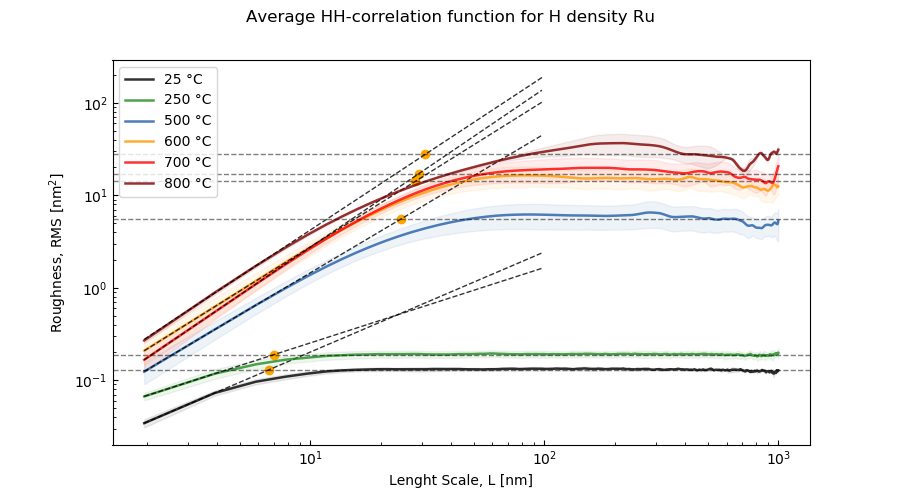

In [58]:
# *** Plot everything in one graph:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','250','500', '600', '700', '800']
colors = ['black', 'forestgreen','#225ea8', '#ff9900', '#ff0000', '#800000']

for temp, color in zip(temperatures, colors):
    
    density = 'H'
    
    label = f"{temp} °C"
    ax.loglog(
        x_new[:],
        AvHHcorr[density][temp]['value'][:1000],
        c = color,
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )
    ax.fill_between(
        x_new[:1000],
        AvHHcorr[density][temp]['value_lower'][:1000],
        AvHHcorr[density][temp]['value_upper'][:1000],
        color = color,
        alpha = 0.075
    )
    
    ax.loglog(
        x_new[interval[dens][temp]['x0']:50], 
        Model(x_new[interval[dens][temp]['x0']:50],*fit[density][temp]['results']), 
        linewidth = 1, 
        linestyle='dashed', 
        alpha = 0.8, 
        c ='k')
    ax.scatter(fit[density][temp]['corrlen'], fit[density][temp]['limit'], marker='o', color='orange')
    ax.axhline(fit[density][temp]['limit'], linestyle="dashed",linewidth = 1, color = 'black', zorder =5, alpha =0.5)
    

    label = None
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
ax.set(ylabel='Roughness, RMS [nm$^2$]')
ax.set(xlabel='Lenght Scale, L [nm]')
titl = f"Average HH-correlation function for {density} density Ru"
fig.suptitle(titl)

figname = f"{titl}.png"
fig.savefig(f"{new_folder_name}/AFM_Average HH function - Ru_{density}_z{z_score}.png",dpi=600)

In [ ]:
temperatures = ['800','700','600','500','250','25']
# temperatures = ['25','250','500','600','700','800']
densities = ['H','LH','L']
Si = ['20']
# colors = ['#800000','#ff0000','#ff9900', '#225ea8', 'forestgreen','black' ]
named_colorscales = px.colors.named_colorscales()
colors = px.colors.sequential.Plasma_r[2:8]

#           'H'       'LH'        'L'
symbols = ['circle', 'square', 'diamond',]


for dens, symbol in zip(densities, symbols):
    
    fig = go.Figure()
    for temp, color in zip(temperatures, colors):
        
    
        label = f"{temp}°C"
        
        fig.add_shape(
            dict(
                type ="line", 
                x0 = x_new[0],
                x1 = 1000,
                y0= fit[dens][temp]['limit'],
                y1 = fit[dens][temp]['limit'],
                opacity = 0.4,
                line = dict(
                    color = 'black',
                    dash = 'dot',
                    width = 1
                ),
            )
        )
            
        fig.add_trace(
            go.Scatter(
                x = x_new[:1000], 
                y = AvHHcorr[dens][temp]['value'][:1000],
                mode = 'lines+markers',
                name = label,
                marker = dict(color = color, 
                              symbol = symbol,
                              opacity = 1, 
                              size = 6,
                             ),
                opacity = 0.8,
                line = dict(
                    color = color,
                    width = 1.8
                )
            )
        ) 
        

        fig.add_trace(
            go.Scatter(
                x = x_new[:50], 
                y = Model(x_new[:50],*fit[dens][temp]['results']),
                opacity = 0.5,
                line = dict(
                    color = 'black',
                    dash = 'dot',
                    width = 1
                    ),
                showlegend=False
            )
        )   
        
        fig.add_trace(
            go.Scatter(
                x = [fit[dens][temp]['corrlen']], 
                y = [fit[dens][temp]['limit']],
                opacity = 0.8,
                marker = dict(
                    color = 'black',
                    size = 9
                ),
                showlegend=False
            )
        )
        
        
    fig.update_layout(title={'text': f'Average HH-correlation function for {dens} density Ru', 
                        'xanchor':'center', 'yanchor': 'top', 'y':0.9,  'x':0.5},
                   xaxis=dict(title='Length scale, L (nm)', ticks="inside",
                              range=[np.log10(1.9),np.log10(1000)],
#                               linewidth=1, linecolor='black', mirror=True
                             ),
                   yaxis=dict(title='HHcorr (nm²)', ticks="inside",
                              range=[np.log10(min(AvHHcorr[dens][temp]['value']*0.9)),
                                     np.log10(max(AvHHcorr[dens]['800']['value']*1.3))],
#                               linewidth=1, linecolor='black', mirror=True
                             ),
#                    template ="plotly_white",
                   width=800, height=600
                  )
        
    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")
    
    fig.write_image(f"images_2020/AFM_Average HH function - Ru_{dens}_withSi_z{z_score}_PLOTLY.png")
    fig.write_image(f"images_2020/AFM_Average HH function - Ru_{dens}_withSi_z{z_score}_PLOTLY.svg") 
    
fig.show()
 


In [ ]:
# *** If I want to see each single HHcorr function (interpolated but not averaged)
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','250','500','600','700','800']
colors = ['black','forestgreen', '#225ea8', '#ff9900', '#ff0000', '#800000']

for temp, color in zip(temperatures, colors):
    selection = df[df.temp==temp]
    selection = selection[selection.density=='LH']
    label = temp
    for idx, row in selection.iterrows():
        ax.loglog(
            x_new[1:],
            row.hhcorr_interp[1:],
            c = color,
            alpha = 0.6,
            linewidth = 1.4,
            label = label
        )
        ax.scatter(x_new[1], row.hhcorr_interp[1], c='darkblue', zorder=10)
        label = None
ax.legend()
titl = f"All HH-correlation functions in one plot - High density Ru"
fig.suptitle(titl)
ax.xaxis.grid() # vertical lines
figname = f"{titl}.png"
fig.savefig(f'Average HH function - Low-High density Ru.png', dpi=600)

